In [2]:
import os
from pathlib import Path
from astropy.io import fits
import numpy as np
import pandas as pd

#pad naar de betreffende metingen, deze moet veranderd worden
path = "C:/Users/Arnau/Documents/NS Practicum 2/Zonnefysica Experiment/map/"
files =  [ p for p in Path(path).glob('*.fit') ]

data_dict = dict()
for file in files:
    data_dict[os.path.basename(file)] = fits.getdata(file)

data_headers = dict()
for x in data_dict.keys():
    data_headers[x] = fits.getheader(path + x)

In [3]:
def import_files(path, filename):
    '''
    Import files in the syntax that I used in the notebook. That is, choose the path that contains
    all the fit files, then for the filename choose something like bias* to obtain all bias files
    as a dictionary that can be accessed by filename 
    '''
    files =  [ p for p in Path(path).glob(filename) ]
    file_dict = dict()
    for file in files:
        file_dict[os.path.basename(file)] = fits.getdata(file) # key of the dict is the filename.

    headers_dict = dict()
    for x in file_dict.keys():
        headers_dict[x] = fits.getheader(path + x)

    return file_dict, headers_dict 

bias_dict, bias_headers = import_files(
    path="C:/Users/Arnau/Documents/NS Practicum 2/Zonnefysica Experiment/map/",
    filename="bias*"
)
bias_dict

{'Bias-0001.fit': array([[339, 318, 312, ..., 350, 298, 324],
        [329, 335, 323, ..., 322, 328, 310],
        [307, 311, 304, ..., 304, 306, 306],
        ...,
        [346, 311, 299, ..., 332, 315, 317],
        [320, 306, 329, ..., 332, 289, 298],
        [291, 323, 320, ..., 305, 306, 292]], dtype=uint16),
 'bias-001.fit': array([[264, 279, 264, ..., 259, 257, 244],
        [266, 287, 275, ..., 279, 280, 277],
        [254, 279, 253, ..., 284, 263, 299],
        ...,
        [260, 276, 271, ..., 273, 269, 262],
        [265, 274, 246, ..., 288, 270, 266],
        [247, 277, 253, ..., 249, 262, 274]], dtype=uint16)}

Flat

In [4]:
def stack(values):
    return  np.median( [ x for x in values ], axis=0 )

flat = fits.getdata("flat-0001.fit" )
light = fits.getdata("skyspectrum zenit-0001.fit" )

bias_master = stack( bias_dict.values() )

light_sum_before = np.sum (light, axis=0)
light_sum = np.sum( light - bias_master, axis=0)

flat_sum_before = np.sum (flat, axis=0)
flat_sum = np.sum( flat - bias_master, axis=0)

flat_scaled = flat_sum / np.median(flat_sum)
light_scaled = light_sum / flat_scaled
flat_scaled

array([0.16402192, 0.16436961, 0.16484778, ..., 0.99732536, 1.00385872,
       0.00412058])

vega

In [5]:
vega_light = fits.getdata("Vega-0005_2s.fit" )
flat = fits.getdata("flat_alt-0001.fit" )
vega_light
np.sum(vega_light, axis=0)

array([384449, 384736, 384201, ..., 359671, 360411, 321317], dtype=uint32)

355506.5

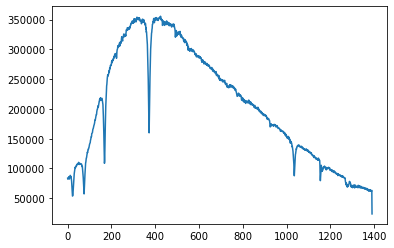

In [6]:
import matplotlib.pyplot as plt
vega_sum = np.sum(vega_light - bias_master, axis=0)
#plt.plot(vega_sum/np.max(vega_sum))
plt.plot(vega_sum)
vega_sum[424]

In [7]:
# From ijking.ipynb
slope = 2.57550836 * .1 # convert from angstrom to nm.
intercept = 3888.85008 * .1 # convert from angstrom to nm.
def pixels_to_wavelenghts(pixels, slope, intercept):
    '''
    This function converts pixel values to wavelengths using a linear model to be determined by a fit.
    '''
    return slope * pixels + intercept
pixels = np.array(range(len(vega_sum)))
wavelengths = pixels_to_wavelenghts(pixels, slope, intercept)
len(wavelengths)

1391

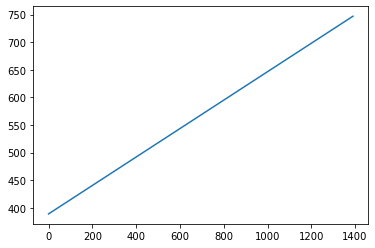

In [8]:
plt.plot(wavelengths)

In [31]:
list_wavelengths = []
for i in wavelengths:
    k = i / (10**9)
    list_wavelengths.append(k)

list_vega = []
for i in vega_sum:
    k = i/np.max(vega_sum)
    list_vega.append(k)

Text(0, 0.5, 'Relative spectral irradiance $Wm^{-2}nm^{-1}$')

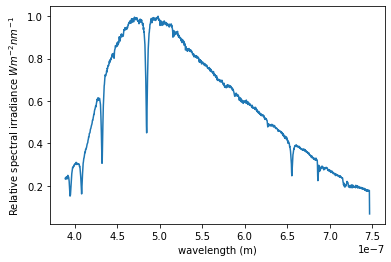

In [10]:
plt.plot(list_wavelengths, list_vega)
plt.xlabel('wavelength (m)')
plt.ylabel('Relative spectral irradiance $Wm^{-2}nm^{-1}$')

In [11]:
from lmfit import models
import scipy.constants as sc
import astropy.constants as ac

R_vega = 1.6 * (10**9)
d_vega = 25.05 * (9.46*(10**15))

planck_curve = lambda wavelength, temperature: ((R_vega/d_vega)**2)*( 2 * sc.Planck * (sc.speed_of_light ** 2) ) / ( (wavelength**5) * ( np.exp( ( sc.Planck * sc.speed_of_light) / ( wavelength * sc.k * temperature ) ) - 1 ) )
model_curve = models.Model(planck_curve, name='fit')
fit = model_curve.fit(list_vega, wavelength=list_wavelengths, temperature=9600)
fit

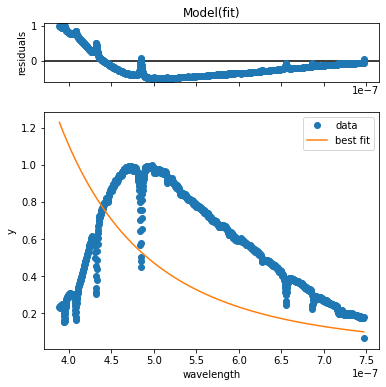

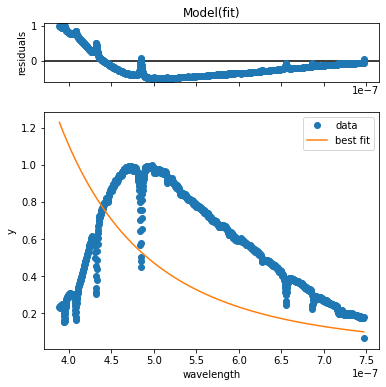

In [12]:
fit.plot()

In [13]:
S = []
temp = 9600
test_wavelength = np.arange(1, 2000, 1)
test_wavelength_nm = [ x / (10**9) for x in test_wavelength]
for i in test_wavelength_nm:
    mini_S = ((R_vega/d_vega)**2)*( 2 * sc.Planck * (sc.speed_of_light ** 2) ) / ( (i**5) * ( np.exp( ( sc.Planck * sc.speed_of_light) / ( i * sc.k * temp ) ) - 1 ) )
    S.append(mini_S)
mini_S

C:\Users\Arnau\AppData\Local\Temp/ipykernel_44964/3150743122.py:6: RuntimeWarning: overflow encountered in exp
  mini_S = ((R_vega/d_vega)**2)*( 2 * sc.Planck * (sc.speed_of_light ** 2) ) / ( (i**5) * ( np.exp( ( sc.Planck * sc.speed_of_light) / ( i * sc.k * temp ) ) - 1 ) )


0.00015235907712809275

Text(0, 0.5, 'Relative spectral irradiance $Wm^{-2}nm^{-1}$')

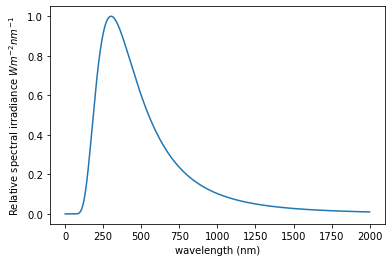

In [14]:
plt.plot(test_wavelength, (S/np.max(S)))
plt.xlabel('wavelength (nm)')
plt.ylabel('Relative spectral irradiance $Wm^{-2}nm^{-1}$')

Getting rid of absorption lines

In [15]:
from scipy.signal import find_peaks, peak_prominences
peaks, _ = find_peaks(vega_sum)
peaks

array([   6,   12,   15,   34,   39,   42,   44,   50,   54,   56,   58,
         62,   66,   90,   93,  107,  125,  131,  139,  146,  148,  150,
        157,  183,  189,  192,  195,  197,  201,  204,  207,  209,  213,
        215,  218,  221,  229,  233,  237,  239,  241,  247,  256,  258,
        261,  264,  268,  270,  272,  274,  279,  281,  283,  287,  290,
        295,  299,  303,  306,  309,  311,  316,  318,  324,  326,  328,
        333,  339,  341,  344,  347,  349,  355,  358,  360,  390,  393,
        399,  402,  404,  412,  415,  419,  421,  424,  428,  430,  437,
        440,  444,  447,  452,  456,  460,  462,  465,  467,  471,  474,
        477,  481,  484,  486,  496,  499,  501,  504,  506,  510,  513,
        516,  520,  525,  527,  532,  535,  542,  545,  548,  551,  554,
        556,  560,  565,  567,  569,  572,  574,  578,  583,  586,  590,
        594,  596,  599,  601,  605,  607,  610,  612,  614,  616,  619,
        621,  625,  629,  632,  635,  637,  641,  6

In [16]:
prominences = peak_prominences(vega_sum, peaks)[0]
prominences

array([3.955500e+03, 6.448000e+03, 1.043000e+03, 8.690000e+02,
       4.340000e+02, 3.295000e+02, 4.785000e+02, 5.297150e+04,
       9.265000e+02, 1.820500e+03, 2.470000e+02, 9.415000e+02,
       3.225000e+02, 9.975000e+02, 1.995000e+02, 1.970000e+02,
       3.240000e+02, 1.105000e+02, 1.881000e+03, 1.131500e+03,
       2.405000e+02, 1.100825e+05, 3.213500e+03, 2.318000e+03,
       2.238500e+03, 1.352000e+03, 8.550000e+01, 5.865000e+02,
       2.485000e+03, 1.765500e+03, 7.780000e+02, 9.545000e+02,
       1.460000e+03, 2.785500e+03, 1.718500e+03, 8.048500e+03,
       2.117500e+03, 1.926000e+03, 5.438500e+03, 1.888000e+03,
       2.612000e+03, 7.155000e+03, 4.362000e+03, 2.535500e+03,
       1.868000e+03, 2.552000e+03, 1.064500e+03, 7.180000e+02,
       3.040000e+02, 3.121500e+03, 2.670000e+03, 1.161000e+03,
       1.372500e+03, 9.050000e+01, 7.080000e+02, 3.860000e+03,
       3.305500e+03, 5.968500e+03, 4.926500e+03, 3.885000e+02,
       3.691500e+03, 1.940605e+05, 2.144500e+03, 1.9880

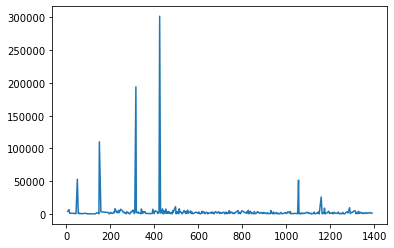

In [17]:
plt.plot(peaks, prominences)

In [18]:
filtered_peaks = []
filtered_pixel = []
n=0
k=0
for i in prominences:
    if i > 15000:
        j = peaks[n]
        filtered_peaks.append(j)
        filtered_pixel.append(i)

    n+=1

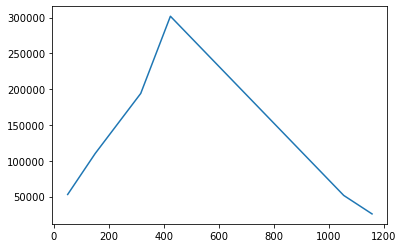

In [19]:
plt.plot(filtered_peaks, filtered_pixel)

In [20]:
filtered_peaks

[50, 150, 316, 424, 1055, 1158]

new approach

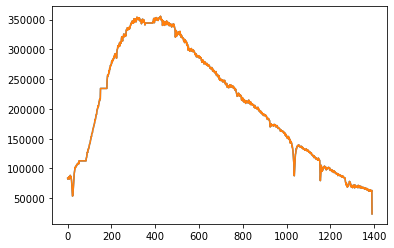

In [32]:
xx = [355, 390]
yy = [vega_sum[355], vega_sum[390]]
plt.plot(vega_sum)
#plt.scatter(x, y, color='red')

outside_average = (vega_sum[354] + vega_sum[391])/2

for i in range(355, 390, 1):
    vega_sum[i] = outside_average

plt.plot(vega_sum)

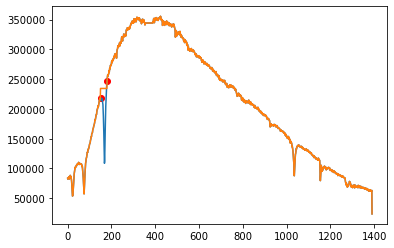

In [23]:
xx = [150, 180]
yy = [vega_sum[150], vega_sum[180]]
plt.plot(vega_sum)
plt.scatter(xx, yy, color='red')

outside_average = (vega_sum[149] + vega_sum[181])/2

for i in range(150, 180, 1):
    vega_sum[i] = outside_average

plt.plot(vega_sum)

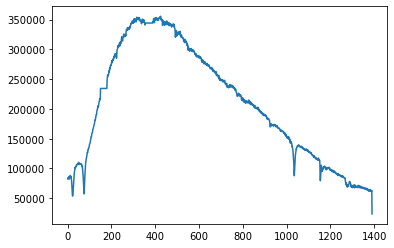

In [24]:
plt.plot(vega_sum)

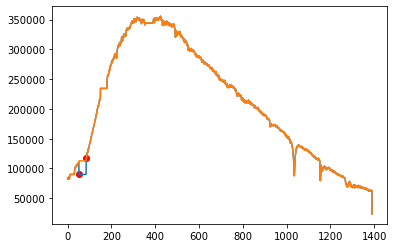

In [35]:
xx = [52, 85]
yy = [vega_sum[52], vega_sum[85]]
plt.plot(vega_sum)
plt.scatter(xx, yy, color='red')

outside_average = (vega_sum[51] + vega_sum[86])/2

for i in range(52, 85, 1):
    vega_sum[i] = outside_average

plt.plot(vega_sum)

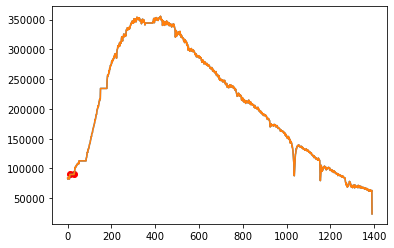

In [36]:
xx = [10, 30]
yy = [vega_sum[10], vega_sum[30]]
plt.plot(vega_sum)
plt.scatter(xx, yy, color='red')

outside_average = (vega_sum[9] + vega_sum[31])/2

for i in range(10, 30, 1):
    vega_sum[i] = outside_average

plt.plot(vega_sum)

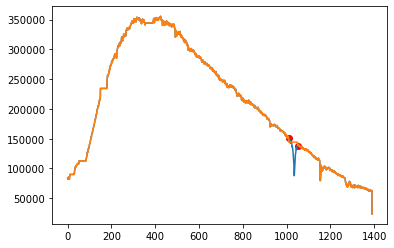

In [40]:
xx = [1010, 1050]
yy = [vega_sum[1010], vega_sum[1050]]
plt.plot(vega_sum)
plt.scatter(xx, yy, color='red')

outside_average = (vega_sum[1009] + vega_sum[1051])/2

for i in range(1010, 1051, 1):
    vega_sum[i] = outside_average

plt.plot(vega_sum)

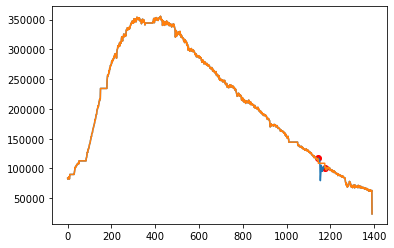

In [44]:
xx = [1145, 1175]
yy = [vega_sum[1145], vega_sum[1175]]
plt.plot(vega_sum)
plt.scatter(xx, yy, color='red')

outside_average = (vega_sum[1144] + vega_sum[1176])/2

for i in range(1145, 1175, 1):
    vega_sum[i] = outside_average

plt.plot(vega_sum)

In [ ]:
x = []
y = []
for n in range(len(vega_sum)):
    lower = vega_sum[n-1]
    base = vega_sum[n]
    higher = vega_sum[n+1]
    lower_dif = abs(base - lower)
    higher_dif = abs(higher - base)
    if lower_dif > 20000:
        if higher_dif > 20000:
            print(vega_sum[n])
            x.append(n)
            print(n)
            y.append(vega_sum[n])
plt.plot(x, y, color='red')

157654.0
170


IndexError: index 1391 is out of bounds for axis 0 with size 1391